# COVID-19 testing by country (R)

 - Task 1: Get a COVID-19 pandemic Wiki page using HTTP request
 - Task 2: Extract COVID-19 testing data table from the wiki HTML page
 - Task 3: Pre-process and export the extracted data frame
 - Task 4: Get a subset of the extracted data frame
 - Task 5: Calculate worldwide COVID testing positive ratio
 - Task 6: Get a sorted name list of countries that reported their testing data
 - Task 7: Identify country names with a specific pattern
 - Task 8: Pick two countries you are interested in, and then review their testing data
 - Task 9: Compare which one of the selected countries has a larger ratio of confirmed cases to population
 - Task 10: Find countries with confirmedcases to population ratio rate less than a threshold

In [4]:
# Libraries
library(tidyverse)
library(httr2)
library(rvest)

In [ ]:
# Page dl helper
pdl <- function(url, timeout = 10) {
    # The helper downloads the target URL.

    headers <- c(
        "User-Agent" = paste(
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "AppleWebKit/537.36 (KHTML, like Gecko)",
        "Chrome/120.0 Safari/537.36"
        ),
        "Accept" = "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language" = "en-GB,en;q=0.9",

        "Accept-Encoding" = "gzip, deflate, br",
        "DNT" = "1",
        "Connection" = "keep-alive",
        "Upgrade-Insecure-Requests" = "1",
        "Referer" = "https://www.google.com/"
    )

    req <- request(url) |>
        req_headers(!!!as.list(headers)) |> # Splice the elements into arguments with tidy !!!
        req_timeout(timeout)

    resp <- tryCatch(
        req_perform(req),
        error = function(e) {
        message("Page not downloaded:\nURL: ", url, " (", conditionMessage(e), ")")
        return(NULL)
        }   
    )

    status <- resp_status(resp)

    if (is.null(resp) || status < 200L || status >= 300L) {
        message("Page not downloaded:\nURL: ", url, "(", status, ")")
        return(NULL)
    }

    return(resp)
}

# Persistent dl helper
pdlf <- function(timeout = 10) {
    # The helper downloads the target URL within a persistent session.
    # Assingn pdlf() to ppdl and call ppdl() on urls within a loop

    headers <- c(
        "User-Agent" = paste(
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "AppleWebKit/537.36 (KHTML, like Gecko)",
            "Chrome/120.0 Safari/537.36"
        ),
        "Accept" = "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language" = "en-GB,en;q=0.9"
    )

    h <- curl::new_handle()

    function(url) {
        req <- request(url) |>
            req_headers(!!!as.list(headers)) |>
            req_timeout(timeout) |>
            req_options(handle = h)

    status <- resp_status(resp)

    resp <- tryCatch(req_perform(req), error = function(e) NULL)
    if (is.null(resp) || status < 200L || status >= 300L) return(NULL)

    return(resp)
  }
}

## Tasks 1 through 4

In [6]:
# URL
    # Template page
url1 <- r"(https://en.wikipedia.org/w/index.php?title=Template:COVID-19_testing_by_country)"
    # Current page
url2 <- r"(https://en.wikipedia.org/wiki/COVID-19_testing)"

In [ ]:
# Download the page
wiki_page <- pdl(url2)

In [101]:
# Extract the tab
tab <- wiki_page |>
    resp_body_string() |>
    read_html() |>
    html_table()

df <- tab[[3]]

df |>
    head()

Country or region,Date[a],Tested,Units[b],Confirmed(cases),"Confirmed /tested,%","Tested /population,%","Confirmed /population,%",Ref.
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Afghanistan,17 Dec 2020,"154,767",samples,"49,621",32.1,0.40,0.13,[248]
Albania,18 Feb 2021,"428,654",samples,"96,838",22.6,15.0,3.4,[249]
Algeria,2 Nov 2020,"230,553",samples,"58,574",25.4,0.53,0.13,[250][251]
Andorra,23 Feb 2022,"300,307",samples,"37,958",12.6,387,49.0,[252]
Angola,2 Feb 2021,"399,228",samples,"20,981",5.3,1.3,0.067,[253]
Antigua and Barbuda,6 Mar 2021,"15,268",samples,832,5.4,15.9,0.86,[254]


In [102]:
# Clean-up
df <- df |>
    # Clean col names
    janitor::clean_names() |>
    rename(date = date_a) |>
    rename(units = units_b)

In [ ]:
df <- df |>
    # Format dates
    mutate(
        date = if_else(nchar(date) > nchar("dd bbb yyyy"), NA, date),
        date = parse_date_time(date, orders = "d b Y", quiet = TRUE)
    ) |>
    # Filter out footnotes
    filter(!is.na(date)) |>
    # Format numeric cols
    mutate(
        across(
            .cols = c(
                colnames(df)[str_detect(colnames(df), "tested")],
                colnames(df)[str_detect(colnames(df), "confirmed")]
            ),
            .fns = ~ as.numeric(str_replace_all(.x, ",", ""))
        )
    ) |>
    # Clean up entity names
    mutate(
        country_or_region = str_replace_all(country_or_region, "\\[.*?\\]", "")
    )

df |>
    sample_n(10)

country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
<chr>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Oman,2020-10-28,509959,samples,114434,22.4,11.0,2.500,[383]
Myanmar,2021-09-16,4047680,samples,440741,10.9,7.4,0.810,[369]
Finland,2022-01-14,9042453,samples,371135,4.1,163.0,6.700,[309]
Cuba,2023-02-02,14301394,samples,1112470,7.8,126.0,9.800,[290][291]
Liberia,2021-07-17,128246,,5396,4.2,2.5,0.110,[348]
Dominican Republic,2022-07-22,3574665,samples,626030,17.5,32.9,5.800,[298]
Japan,2021-03-01,8487288,,432773,5.1,6.7,0.340,[337]
Angola,2021-02-02,399228,samples,20981,5.3,1.3,0.067,[253]
Serbia,2023-02-02,12185475,cases,2473599,20.3,175.0,35.500,[405]


In [104]:
# Dimension check
d <- dim(df)

sprintf("%d rows and %d cols.", d[1], d[2])

[1] "172 rows and 9 cols."

## Task 5: Calculate worldwide COVID testing positive ratio

In [106]:
# Global confirmed / tested ratio
confirmed_tested <- sum(df["confirmed_cases"]) / sum(df["tested"])

cat(round(confirmed_tested * 100, 2), "% of the tested have been confirmed globally.")

7.99 % of the tested have been confirmed globally.

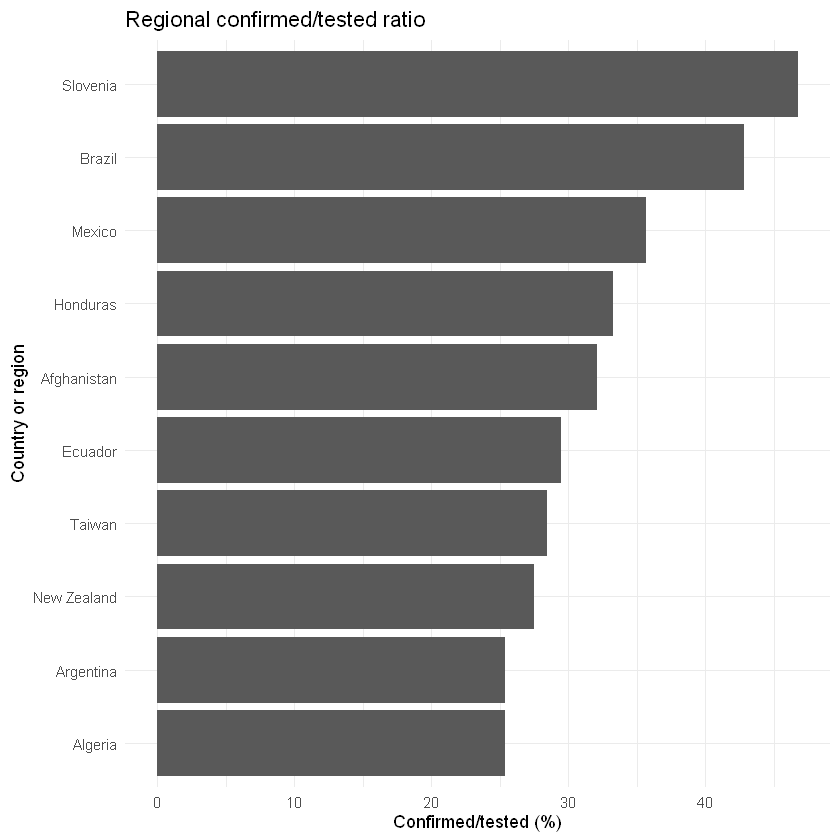

In [112]:
# Top 10 confirmed per country
gg_df1 <- df |>
    arrange(desc(confirmed_tested_percent)) |>
    slice(seq(10)) |>
    # Construct a factor for ggplot
    mutate(
        country_or_region = fct_reorder(country_or_region, confirmed_tested_percent)
    )

ggplot(gg_df1, aes(x=country_or_region, y=confirmed_tested_percent)) +
    geom_bar(stat="identity") + 
    coord_flip() + 
    theme_minimal() +
    labs(
        title="Regional confirmed/tested ratio",
        x="Country or region", 
        y="Confirmed/tested (%)"
    )

## Task 6: Get a sorted name list of countries that reported their testing data